# EX 3: **Neural Networks**

In [1]:
# import some libraries we'll need
import numpy as np
from matplotlib import pyplot as plt
import torch

C:\Users\qraus\anaconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*Suppose we have a neural network with two inputs, two hidden layers of 8 units each, ReLU activations (except for $\hat y = f_\text{out}(h_L)$) and one output.*

* *Write an algorithm using python to compute the NN output $\hat y$ given the input and the free parameters (weights and biases)*
* *Write an algorithm to compute derivatives of the least squares loss $(y - \hat y)^2$ with respect to all free parameters of the NN. This should be a python function that takes the free parameters, NN inputs $x$ and NN training targets $y$ as its own inputs.* ***Don't use automatic differntiation, finite differences or symbolic math tools: do the derivatives by hand!***
* ***Optional challenge problem (+25% of assignment max. points), skip for now if you get stuck***: *Extend your derivative computation algorithm to work with any number of hidden layers, all of which can have different numbers of hidden units.*

## The first small Network

* *Write an algorithm using python to compute the NN output $\hat y$ given the input and the free parameters (weights and biases)*

In [274]:
units = 8
x = np.random.random((1,2))
W1   = np.random.random((2,units)) # #umgedreht
W2   = np.random.random((units,units))
Wout = np.random.random((units,1))

b1   = np.random.random((1,units))
b2   = np.random.random((1,units))
bout = np.random.random((1,1))

weights = [W1, W2, Wout]
biases  = [b1, b2, bout]

y = np.random.random((1,1))

In [275]:
def forward(x,weights,biases):
    z1 = np.dot(x,weights[0]) + biases[0]
    h1 = np.maximum(np.zeros(z1.shape),z1)

    z2 = np.dot(h1,weights[1]) + biases[1]
    h2 = np.maximum(np.zeros(z2.shape),z2)   
    yhat = np.dot(h2, weights[2]) + biases[2]
    
    print(z1.shape,h1.shape,z2.shape,h2.shape,yhat.shape)

    return yhat, h2, z2, h1, z1
yhat, h2, z2, h1, z1 = forward(x,weights,biases)
print(yhat)    


(1, 8) (1, 8) (1, 8) (1, 8) (1, 1)
[[26.66057456]]


* *Write an algorithm to compute derivatives of the least squares loss $(y - \hat y)^2$ with respect to all free parameters of the NN. This should be a python function that takes the free parameters, NN inputs $x$ and NN training targets $y$ as its own inputs.* ***Don't use automatic differntiation, finite differences or symbolic math tools: do the derivatives by hand!***

In [276]:
def d_ReLU(x):
    x[x<=0] = 0
    x[x >0] = 1
    return x

In [278]:
def backward(x,y,weights,biases,layers):
    h1,h2,yhat = layers
    e = (y-yhat)**2                                  # [1x1]

    de_dyhat = -2 *(y-yhat).T                        # [1x1]
    dWout  = np.dot(h2.T,-2 *(y-yhat))               # [8x1] 
    dbout  = -2 *(y-yhat).T #?                       # [1x1]

    z2     = np.dot(h1,weights[1]) + biases[1]
    de_dh2 = np.dot(de_dyhat,weights[2].T)           # [1x8]   
    dW2    = np.dot(h1.T,d_ReLU(z2)*de_dh2)#?        # [8x8]
    db2    = d_ReLU(z2)*de_dh2                       # [1x8]

    z1     = np.dot(x,weights[0]) + biases[0] 
    de_dh1 = np.dot(d_ReLU(z2)*de_dh2, weights[1].T) # [1x8]
    dW1    = np.dot(x.T,(d_ReLU(z1)*de_dh1))#?       # [2x8]
    de_db1 = d_ReLU(z1)*de_dh1 #!?                   # [1x8]
    
    print(e.shape,de_dyhat.shape,dWout.shape,dbout.shape,de_dh2.shape,dW2.shape,db2.shape,de_dh1.shape,dW1.shape,de_db1.shape)
    
backward(x,y,weights,biases,[h1,h2,yhat])

(1, 1) (1, 1) (8, 1) (1, 1) (1, 8) (8, 8) (1, 8) (1, 8) (2, 8) (1, 8)


* ***Optional challenge problem (+25% of assignment max. points), skip for now if you get stuck***: *Extend your derivative computation algorithm to work with any number of hidden layers, all of which can have different numbers of hidden units.*

In [296]:
# create weights and biases

x = np.array([[1,-1]])
units = [8,8,8]
len_input = x.shape[1]
y = np.random.random((1,1))

weights = []
biases = []
weights.append(np.random.random(( units[0],len_input)))
biases.append(np.random.random((units[0],1)))
for i in range(1,len(units)):  
    weights.append(np.random.random((units[i],units[i-1])))
    biases.append(np.random.random((units[i],1)))
weights.append(np.random.random((1,units[-1])))
biases.append(np.random.random((1, 1)))

In [297]:
def forward(x,weights,biases):
    layers = []
    layers.append(x)
    z = np.dot(weights[0],x.T) + biases[0]
    h = np.maximum(np.zeros(z.shape),z) 
    layers.append(h)
    for i in range(len(weights)-2):
        z = np.dot(weights[i+1],h) + biases[i+1]
        h = np.maximum(np.zeros(z.shape),z) 
        layers.append(h)
    yhat = np.dot(weights[-1],h) + biases[-1]

    return yhat, layers
yhat,layers= forward(x,weights,biases)
print(yhat)
print(len(layers))

[[59.88516896]]
4


In [298]:
def backward(x,y,weights,biases,layers):
    dh_l = []
    dW_l = []
    db_l = []
    
    e = (y-yhat)**2                                 # [1x1]
    dyhat = -2 *(y-yhat).T                          # [1x1]
    dWout = np.dot(-2 *(y-yhat),layers[-1].T)       # [1x8] 
    dbout = -2 *(y-yhat).T #?                       # [1x1]
    dh_l.append(dyhat)
    dW_l.append(dWout)
    db_l.append(dbout)
    
    
    dh = np.dot(dyhat,weights[-1])                  # [1x8]
    db = dh.T*d_ReLU(np.dot(weights[-2],layers[-1])+biases[-2])
    dW = dh * np.dot(d_ReLU(np.dot(weights[-2],layers[-1])+biases[-2]),layers[-1].T)
    print(dh.shape,dW.shape,db.shape)
    dh_l.append(dh)
    dW_l.append(dW)
    db_l.append(db)
    
    for j in range(len(layers)-2,1,-1):
        dh = np.dot(dh,d_ReLU(np.dot(weights[j],layers[j])+biases[j])*weights[j])
        dW = dh * np.dot(d_ReLU(np.dot(weights[j-1],layers[j-1])+biases[j-1]),layers[j-1].T)
        db = dh.T * d_ReLU(np.dot(weights[j-1],layers[j-1])+biases[j-1])
        print(dh.shape,dW.shape,db.shape)
        dh_l.append(dh)
        dW_l.append(dW)
        db_l.append(db)
        
    dh = np.dot(dh,d_ReLU(np.dot(weights[1],layers[1])+biases[1])*weights[1])
    dW = dh.T * np.dot(d_ReLU(np.dot(weights[0],layers[0].T)+biases[0]),layers[0])
    db = dh.T * d_ReLU(np.dot(weights[0],layers[0].T)+biases[0])
    print(dh.shape,dW.shape,db.shape)
    dh_l.append(dh)
    dW_l.append(dW)
    db_l.append(db)

backward(x,y,weights,biases,layers)

(1, 8) (8, 8) (8, 1)
(1, 8) (8, 8) (8, 1)
(1, 8) (8, 2) (8, 1)


## Load Data

*We'll now download a data file and extract 3 variables. Each is a NumPy array:*
* `y` *contains monthly values of the [Nino 3.4 ENSO index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni), describing the [El Nino Southern Oscillation](https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation) over time.*
* `x` *contains empirical orthogonal function coefficients that describe the ocean temperature at the sea surface and the depth average over the top 300 meters, in the Indo-Pacific, North-Pacific and Atlantic regions. Essentially, the numbers in each row of $x$ summarize temperatures in the upper ocean across the globe. For details of how these are calculated, you can consult [this paper](https://www.nature.com/articles/s41586-019-1559-7) by Ham et al. Each row of `x` describes the ocean state 2 months before the corresponding element of `y`.*
* `t` *contains the time in months since Jan. 1 1970 for each value of `y`. We can use this for plotting results but it won't appear in our calculations otherwise.*

In [ ]:
# library for downloading files from google drive.
!pip install gdown  

# download the data
!gdown https://drive.google.com/uc?id=1FUb-2lcAd0Y1ULjx5jB6UTMNDmGy3vZA

In [299]:
# load the data
with np.load('./data/enso_and_pca.npz') as data:
    t, x, y = data['t'], data['x'], data['y']

*Normalize `y` and each column of `x` so they all have a mean of zero and a standard deviation of one. Overwrite the original variables `x,y` with the normalized ones, but keep track of what you've done, so you can convert your predictions back into original data units later on if needed.*

In [300]:
y_norm = (y - np.mean(y))/ np.std(y)
print(np.std(y_norm),np.mean(y_norm))
x_norm = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
print(np.std(x_norm[:,0]),np.mean(x_norm[:,0]))

1.0 -6.1876677e-09
0.9999994 -1.0828419e-08


*Last time we wrote a loop by hand to cycle over the data. However, pytorch provides great utilities to do this for us, which will let us focus on what's new in each lesson instead. In particular, we're going to use the PyTorch Dataset and DataLoader classes.*

In [302]:
from torch.utils.data import TensorDataset, DataLoader

# create PyTorch tensors for our inputs and target outputs
xt = torch.tensor(x_norm)
yt = torch.tensor(y_norm)

# use the first 1100 time points as training data
#xt_train, yt_train = xt[:1100], yt[:1100]
xt_train, yt_train = xt[:1104], yt[:1104]

# save the remaining data for testing
xt_test, yt_test = xt[1104:], yt[1104:]

dataset = TensorDataset(xt_train, yt_train)  # combine the inputs and outputs into a PyTorch Dataset object
# create a dataloader to serve up batches of 8 data point for training
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

*Now let's get the first 'batch' of data from the dataloader, and see what it looks like.*

In [303]:
for x_batch, y_batch in data_loader:
    print('shape of x_batch: {0}'.format(x_batch.shape) )
    print('shape of y_batch: {0}'.format(y_batch.shape) )  
    break  # if we didn't have this line, the for loop would cycle through all the data

shape of x_batch: torch.Size([8, 46])
shape of y_batch: torch.Size([8])


## Stochastic gradient decent

*Now use a for loop, iterating over batches from the data loader, to fit a linear regression $\hat y = x\cdot \beta$ with least squares loss, by stochastic gradient descent. Refer back to the code you wrote from the last set of exercises for guidance (and feel free to copy-paste from your own previous homework).*
* *Add an extra column of ones to `x` to incorporate a constant term*
* *Don't forget to set `requires_grad = True` when initializing `beta`*
* *Choose how to initialize $\beta$. All zeros? Random? Does it make much of a difference here?*
* *As before, don't forget to use `with torch.no_grad():` when updating parameters*
* *Store the loss at each iteration of the loop.*
* *Does the loss decrease on the training data? Do you get a positive correlation between $y$ and $\hat y$ at the end on the training data?*
* *See if you can get a better result by adjusting the initialization of free parameters or the learning rate*

In [120]:
def SGD(data_loader, random = False, LR=1e-4, runs=200):
    Loss = []
    Beta = []
    if random:
        beta = torch.rand((1,x_norm.shape[1]+1), requires_grad=True)
    else:
        beta = torch.zeros((1,x_norm.shape[1]+1), requires_grad=True)

    for i in range(runs):
        Beta.append(beta.detach().numpy()[0])
        for x_batch, y_batch in data_loader: 
            x_batch = torch.cat((x_batch,torch.ones(8, 1) ), 1)
            yhat = torch.mm(beta, x_batch.T)
            loss = 1/len(x_batch) * torch.sum((y_batch - yhat)**2)#
            loss.backward()
            with torch.no_grad():
                beta -= beta.grad * LR
                beta.grad.zero_()
            Loss.append(loss.detach().numpy())
    return Loss, Beta, beta.detach().numpy(), yhat.detach().numpy()

In [121]:
Loss, Beta, beta, yhat = SGD(data_loader, random = False)
Loss_r, Beta_r, beta_r, yhat_r = SGD(data_loader, random = True)

* *Choose how to initialize $\beta$. All zeros? Random? Does it make much of a difference here?*

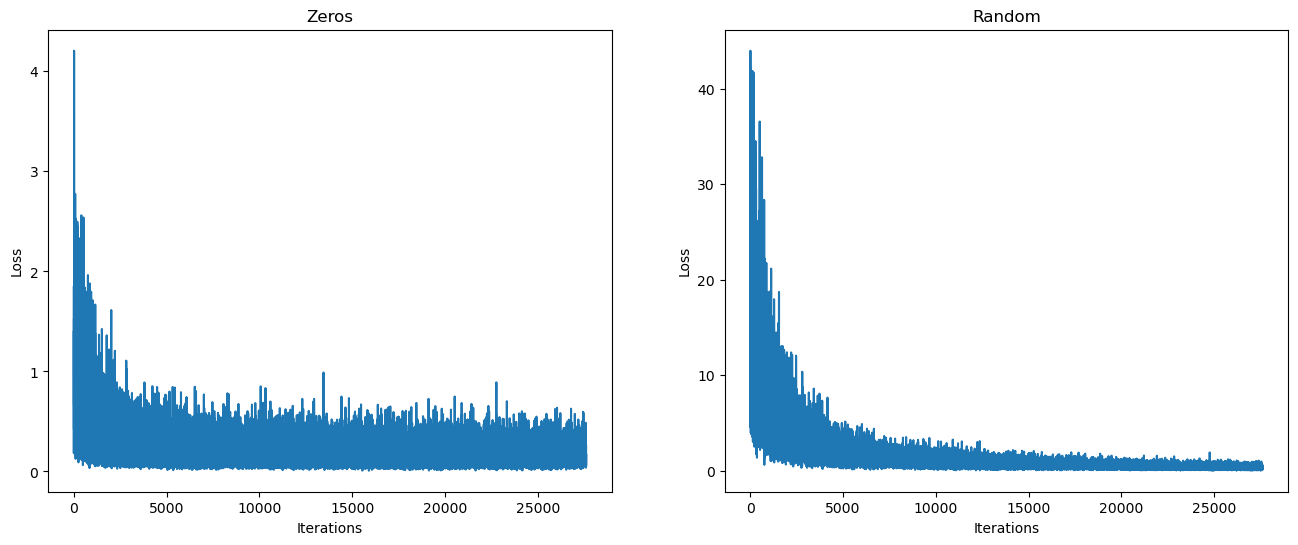

In [122]:
fig = plt.figure(figsize=(16,6))
(ax1, ax2) = fig.subplots(1, 2)
ax1.plot(Loss)
ax1.set_title("Zeros")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iterations")
ax2.plot(Loss_r)
ax2.set_title("Random")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Iterations")
plt.show()

When initializing with zeros the loss function starts with a value about a magnitude smaller and also converges faster than for an initialization with random numbers.

* *Does the loss decrease on the training data? Do you get a positive correlation between $y$ and $\hat y$ at the end on the training data?*

In [123]:
x_corr = torch.cat((xt_train,torch.ones(1104, 1) ), 1)
yhat = np.matmul(beta, x_corr.T.detach().numpy()[:])
correlation = np.corrcoef(yhat,yt_train.detach().numpy()[:])
print(correlation[0,1])

0.9147950866938347


The Loss does decrease with the training data and the correlation is positive at around 91%.

* *See if you can get a better result by adjusting the initialization of free parameters or the learning rate*

In [124]:
yhat = np.matmul(beta_r, x_corr.T.detach().numpy()[:])
correlation = np.corrcoef(yhat,yt_train.detach().numpy()[:])
print(correlation[0,1])

0.8199193211856985


The corralation is worse for random initialization of beta.

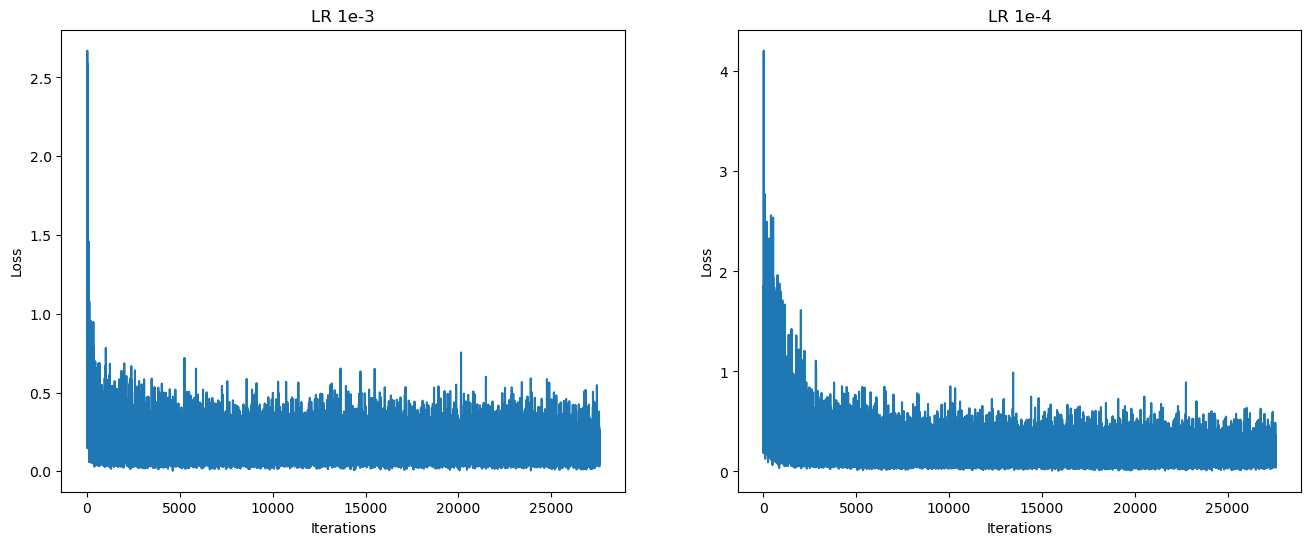

0.9247695848914118


In [125]:
Loss_3, Beta_3, beta_3, yhat_3 = SGD(data_loader, random = False, LR=1e-3, runs=200)
fig = plt.figure(figsize=(16,6))
(ax1, ax2) = fig.subplots(1, 2)
ax1.plot(Loss_3)
ax1.set_title("LR 1e-3")
ax2.plot(Loss)
ax2.set_title("LR 1e-4")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Iterations")
plt.show()

yhat = np.matmul(beta_3, x_corr.T.detach().numpy()[:]) # muss ich die einsen stacken?
correlation = np.corrcoef(yhat,yt_train.detach().numpy()[:])
print(correlation[0,1])

For a learning rate of 1e-3 and the same amount of runs the correlations is slighly better.

## Neural Network for ENSO Data

*Now repeat the process, but instead of a linear model we'll use a neural network with two hidden layers of 32 units each, and the ReLU activation function $\phi(z) = \max(0, z)$. Again we'll use least squares loss and a batch size of 8.*

**Don't** *use PyTorch's built-in classes for this just yet. Instead:*
* *Define tensors of the correct size and data type (check `x.dtype`) for each variable containing free parameters (weights and biases) of your neural network. Remember to set `requires_grad = True` where needed.*
* *For each batch of data, compute the hidden state activations $h_1$ as a function of $W_1, b_1, x$*
* *Then compute $h_2$, $\hat y$ and $e=\ell(y, \hat y)$.*
* *Call `e.backward()` to compute derivatives of $e$ with respect to the free variables of your neural network, using backward-mode differentiation.*
* *Now update all free parameters based on the computed derivatives and the learning rate, just as you did for the linear regression example. Remember to use `with torch.no_grad():`*
* *Plot the convergence of the loss function over iterations. Are you getting a better fit than with the linear regression?*
* *How did you initialize? Does it make a difference now?*

In [306]:
def NN(data_loader, weights, biases, LR=1e-4, runs=200):
    Loss = []

    for i in range(runs):
        for x_batch, y_batch in data_loader:
            h1   = torch.maximum(torch.zeros(1),torch.add(torch.mm(weights[0].float(),x_batch.T.float()), biases[0]))
            h2   = torch.maximum(torch.zeros(1),torch.add(torch.mm(weights[1],h1),biases[1]))
            yhat = torch.add(torch.mm(weights[2],h2), biases[2])
            e    = torch.sum((y_batch-yhat)**2)
            e.backward()
            with torch.no_grad():
                for j in range(len(weights)):
                    weights[j] -= weights[j].grad * LR
                    weights[j].grad.zero_()
                    biases[j] -= biases[j].grad * LR
                    biases[j].grad.zero_()

            Loss.append(e.detach().numpy())
            
    return Loss, weights, biases

In [313]:
def initialize(units = 32,random = True):
    if random:
        n    = x_norm.shape[1]
        W1   = torch.tensor(np.random.random((units,n))*0.1, requires_grad = True)
        W2   = torch.tensor(np.random.random((units,units))*0.1, requires_grad = True)
        Wout = torch.tensor(np.random.random((1,units))*0.1, requires_grad = True)

        b1   = torch.tensor(np.random.random((units,1))*0.1, requires_grad = True)
        b2   = torch.tensor(np.random.random((units,1))*0.1, requires_grad = True)
        bout = torch.tensor(np.random.random((1,1))*0.1, requires_grad = True)

    if not random:
        n    = x_norm.shape[1]
        W1   = torch.tensor(np.zeros((units,n)), requires_grad = True)
        W2   = torch.tensor(np.zeros((units,units)), requires_grad = True)
        Wout = torch.tensor(np.zeros((1,units)), requires_grad = True)

        b1   = torch.tensor(np.zeros((units,1)), requires_grad = True)
        b2   = torch.tensor(np.zeros((units,1)), requires_grad = True)
        bout = torch.tensor(np.zeros((1,1)), requires_grad = True)

    biases  = [b1, b2, bout]
    weights = [W1, W2, Wout]
    return weights, biases

weights, biases = initialize(random = False)
Loss_0, Weights_0, Biases_0 = NN(data_loader, weights, biases)

weights, biases = initialize(random = True)
Loss, Weights, Biases = NN(data_loader, weights, biases)

* *Plot the convergence of the loss function over iterations. Are you getting a better fit than with the linear regression?*

In [315]:
def Forward(x, weights, biases):
    h1   = torch.maximum(torch.zeros(1),torch.mm(weights[0].float(),x.T.float()) + biases[0])
    h2   = torch.maximum(torch.zeros(1),torch.mm(weights[1],h1) + biases[1])
    yhat = torch.mm(weights[2],h2) + biases[2]
    return yhat.detach().numpy()

In [317]:
yhat_train = Forward(xt_train, weights, biases)
cor_NN_train = np.corrcoef(y[:1104],yhat_train)
print(cor_NN_train[0,1])
#0.9247695848914118 Lin Reg


0.9452736011810711


The correlation with the NN after 200 runs is about 2% better than from linear regression.

* *How did you initialize? Does it make a difference now?*

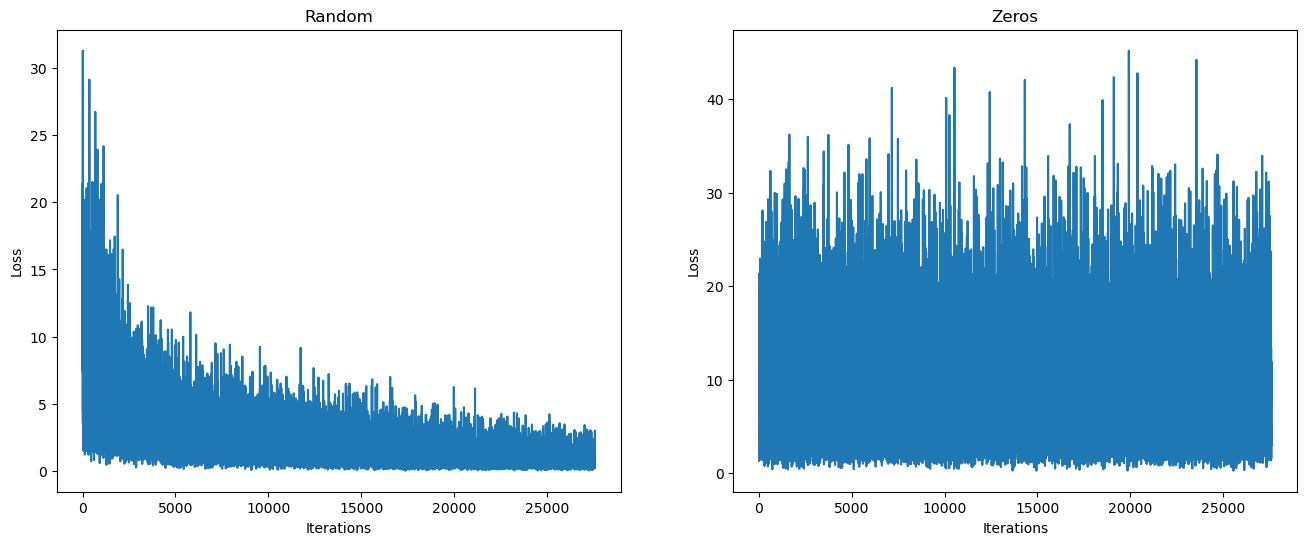

In [314]:
fig = plt.figure(figsize=(16,6))
(ax1, ax2) = fig.subplots(1, 2)
ax1.plot(Loss)
ax1.set_title("Random")
ax2.plot(Loss_0)
ax2.set_title("Zeros")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Iterations")
plt.show()

Initializing with zeros does not seem to converge.

*Now plot the target ENSO 3.4 index values $y$ against the predictions from the linear regression and the neural network. Clearly mark the boundary between training and testing data.*

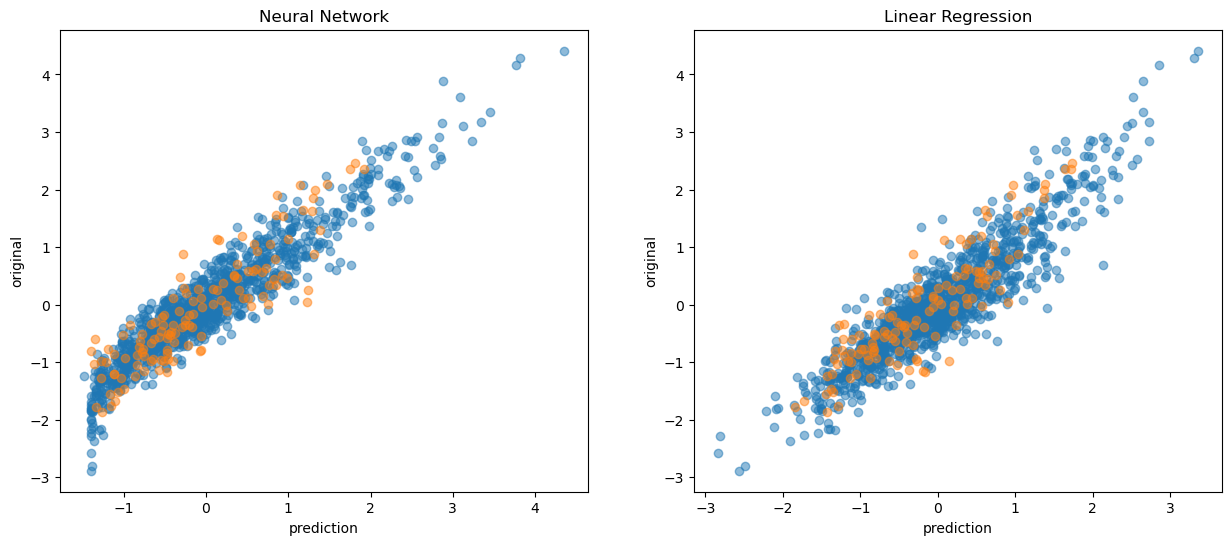

In [318]:
yhat_train = Forward(xt_train, weights, biases)
yhat_test = Forward(xt_test, weights, biases)
yhat_lin_train = np.dot(beta,torch.cat((xt_train,torch.ones(xt_train.shape[0], 1) ), 1).detach().numpy().T)
yhat_lin_test = np.dot(beta,torch.cat((xt_test,torch.ones(xt_test.shape[0], 1) ), 1).detach().numpy().T)

plt.figure(figsize=(7.5*2,6))
plt.subplot(121)
plt.title("Neural Network")
plt.xlabel("prediction")
plt.ylabel("original")
plt.scatter(yhat_train,yt_train.detach().numpy(),label="training",alpha=0.5)
plt.scatter(yhat_test,yt_test.detach().numpy(),label="testing",alpha=0.5)

plt.subplot(122)
plt.title("Linear Regression")
plt.xlabel("prediction")
plt.ylabel("original")
plt.scatter(yhat_lin_train,yt_train.detach().numpy(),label="training",alpha=0.5)
plt.scatter(yhat_lin_test,yt_test.detach().numpy(),label="testing",alpha=0.5)

*What are mean square errors for the NN and linear regression, in original data units, on the testing and training data? How about Pearson's correlation coefficient?*

In [319]:
MSE_NN_train = np.sum((y[:1104]-(yhat_train+np.mean(y))*np.std(y))**2)
MSE_NN_test  = np.sum((y[1104:]-(yhat_test+np.mean(y))*np.std(y))**2)
MSE_LG_train = np.sum((y[:1104] - (yhat_lin_train+np.mean(y))*np.std(y))**2)
MSE_LG_test  = np.sum((y[1104:] - (yhat_lin_test+np.mean(y))*np.std(y))**2)

cor_NN_train = np.corrcoef(y[:1104],(yhat_train+np.mean(y))*np.std(y))
cor_NN_test = np.corrcoef(y[1104:],(yhat_test+np.mean(y))*np.std(y))
cor_LG_train = np.corrcoef(y[:1104],(yhat_lin_train+np.mean(y))*np.std(y))
cor_LG_test = np.corrcoef(y[1104:],(yhat_lin_test+np.mean(y))*np.std(y))

print("MSE Neural Network    TRAINING data: {:.3f}".format(MSE_NN_train))
print("MSE Neural Network    TESTING  data: {:.3f}".format(MSE_NN_test))
print("MSE Linear Regression TRAINING data: {:.3f}".format(MSE_LG_train))
print("MSE Linear Regression TESTING  data: {:.3f}".format(MSE_LG_test))
print()
print("Correlation Neural Network    TRAINING data: {:.3f}".format(cor_NN_train[0,1]))
print("Correlation Neural Network    TESTING  data: {:.3f}".format(cor_NN_test[0,1]))
print("Correlation Linear Regression TRAINING data: {:.3f}".format(cor_LG_train[0,1]))
print("Correlation Linear Regression TESTING  data: {:.3f}".format(cor_LG_test[0,1]))

MSE Neural Network    TRAINING data: 82.125
MSE Neural Network    TESTING  data: 17.507
MSE Linear Regression TRAINING data: 125.269
MSE Linear Regression TESTING  data: 19.654

Correlation Neural Network    TRAINING data: 0.945
Correlation Neural Network    TESTING  data: 0.889
Correlation Linear Regression TRAINING data: 0.915
Correlation Linear Regression TESTING  data: 0.883


## PyTorch Classes

*Now we'll do the same thing, but defining a python object class for our neural network, and some built-in PyTorch classes:*

In [320]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_inputs=46, n_outputs=1, n_hidden=32):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_inputs, n_hidden)  # 5*5 from image dimension
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_outputs)
     
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

*As described in the first two lectures, we are now building our neural net out of composable functions that we can stack together like legos.*

*PyTorch also lets us iterate in loops over the trainable parameters of the model. Note how `requires_grad` was correctly set by default for the learnable parameters.*

In [321]:
net = Net()
for name, param in net.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

fc1.weight: requires_grad=True
fc1.bias: requires_grad=True
fc2.weight: requires_grad=True
fc2.bias: requires_grad=True
fc3.weight: requires_grad=True
fc3.bias: requires_grad=True


*When we use our network object like a function, the input gets passed to the `forward()` method:*

In [322]:
print(net(torch.rand(46)))

tensor([-0.2712], grad_fn=<AddBackward0>)


*We can also provide it with multiple inputs to process independently:*

In [323]:
print(net(torch.rand(4,46)))

tensor([[-0.2575],
        [-0.2951],
        [-0.2544],
        [-0.2366]], grad_fn=<AddmmBackward0>)


*Now redo the training loop from before, but now update the parameters using an inner loop over `net.named_parameters` (remember to use `torch.no_grad()` when updating parameters, and to zero out the derivatives after you do so).*

*Instead of calling `var.grad.zero()` on each trainable variable, we can now also simply call `net.zero_grad()` once.*

***Look up the default initialization of weights and biases in the `nn.Linear` objects you used.***

**Random**

In [324]:
net = Net()
LR   = 1e-4
runs = 200   
Loss = []

for i in range(runs):
    for x_batch, y_batch in data_loader:
        yhat = net(x_batch)
        e = torch.sum((y_batch - torch.squeeze(yhat))**2)
        e.backward()
        with torch.no_grad():
            for name, param in net.named_parameters():
                param -= param.grad *LR
                param.grad.zero_()
        Loss.append(e.detach().numpy())


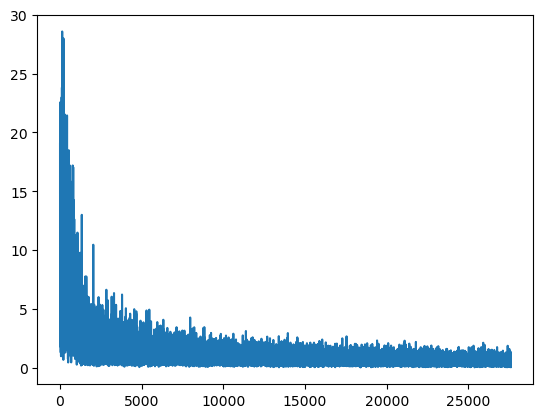

In [325]:
plt.plot(Loss)

*Change the `Net()` class above to allow an adjustable number of hidden layers to be specified when initializing the object, and to specify a different number of hidden units for each hidden layer. Can you get better results on the testing data by adjusting this?*

In [326]:
class Net(nn.Module):
    def __init__(self, n_layers=3, n_inputs=46, n_outputs=1, n_hidden=[32,32,32]):
        super(Net, self).__init__()
        
        Layers = []
        Layers.append(nn.Linear(n_inputs, n_hidden[0]))  # first layer
        for i in range(n_layers-1):                  # other layers
            Layers.append(nn.Linear(n_hidden[i], n_hidden[i+1]))
        Layers.append(nn.Linear(n_hidden[-1], n_outputs)) # output layer
        
        self.layers = nn.ModuleList(Layers)
     
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [327]:
def NN(N,Units,runs=200):
    net  = Net(n_layers=N, n_hidden=Units)
    LR   = 1e-4
    #runs = 200   
    Loss = []

    for i in range(runs):
        for x_batch, y_batch in data_loader:
            yhat = net(x_batch)
            e = torch.sum((y_batch - torch.squeeze(yhat))**2)
            #e = torch.sum((y_batch.reshape(-1,1) - yhat)**2)
            e.backward()
            with torch.no_grad():
                for name, param in net.named_parameters():
                    #print(f'{name}: requires_grad={param.requires_grad}')
                    param -= param.grad *LR
                    param.grad.zero_()
            Loss.append(e.detach().numpy())
    return Loss

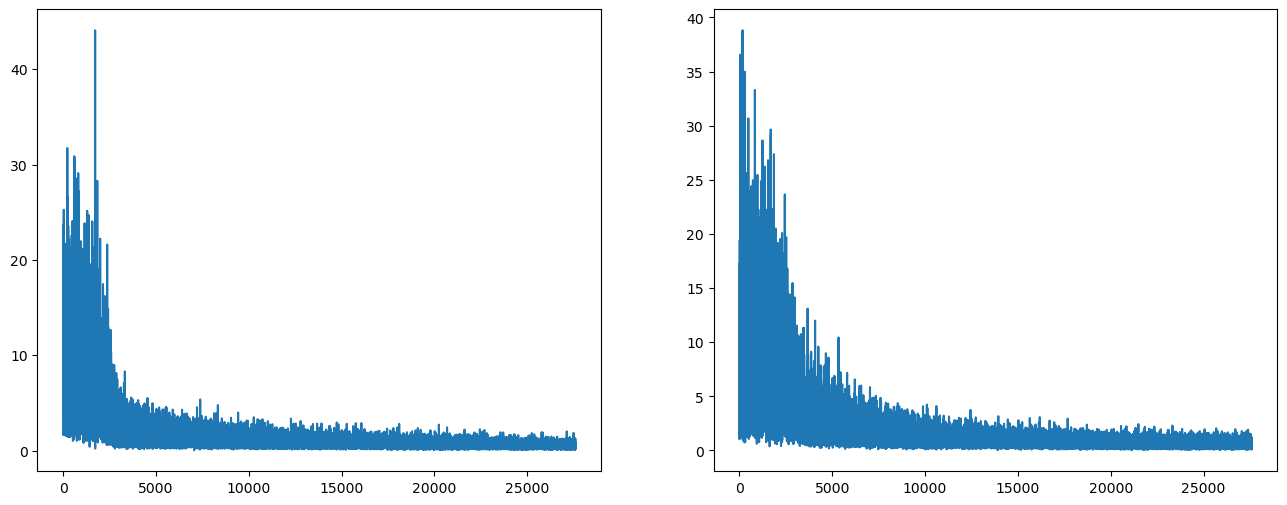

In [344]:
plt.figure(figsize=(8*2,6))
plt.subplot(121)
Loss = NN(3,[32,32,32])
plt.plot(Loss)
plt.subplot(122)
Loss = NN(3,[32,16,8])
plt.plot(Loss)

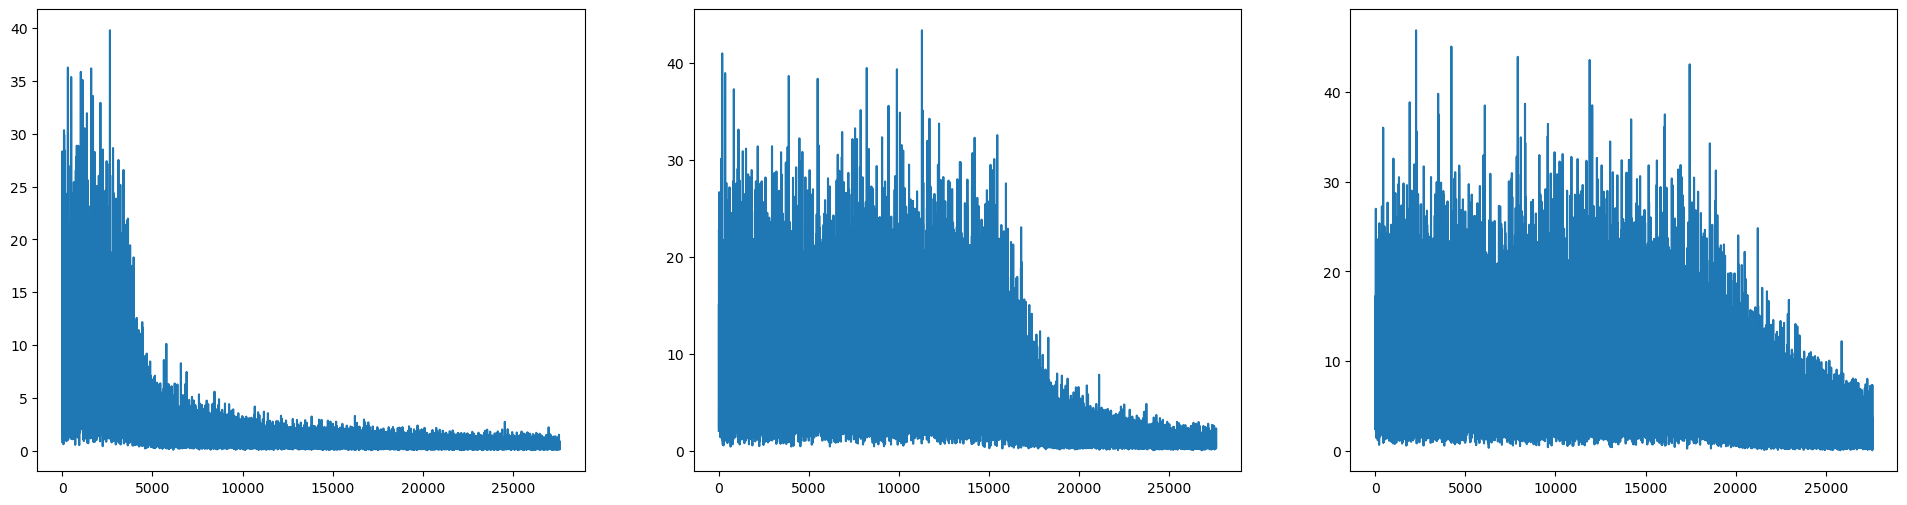

In [341]:
A = [32,32,32,16,16,8,8]
plt.figure(figsize=(8*3,6))
for cnt,N in enumerate([3,5,6]):
    Loss = NN(N,A[:N])
    #Loss = NN(N,n_hidden=A[:N])
    plt.subplot(1,3,cnt+1)
    plt.plot(Loss)
    

Played around a bit but the "default" setting seems kind f hard to beat